# Cross-Correltation of Ambient Seismic Noise
#### A tutorial set for learning the basics of the cross-correlation method for ambient seismic noise correlation

By Thomas Lee, for personal use and final project for EPS522-03: Computational Methods 

In [1]:
%load_ext autoreload
%autoreload 2

##### Correlation Basics

Correlation is a simple mathematic operation that measures the similarity of two functions. Generally, the correlation can be found by taking two functions and multiplying together the output for each function that corresponds to a given input. Then, the multiplied pairs are all summed to give a single correlation value for the two functions. The mathematical notation is quite simple but difficult to show in a Jupyter notebook.

An extremely simple example is shown below.

In [2]:
a = [1, 2, 3]
b = [3, 5, 2]

correlation= a[0]*b[0] + a[1]*b[1] + a[2]*b[2]

So, in this specific case:

In [3]:
correlation = (1*3) + (2*5) + (3*2)

print(f'Correlation of functions a and b: {correlation}')

Correlation of functions a and b: 19


We make several important observations with this basic example. 

One, we don't even need to know the domain as long as we know that the functions have the same lengths. This means that in a sense, our correlation isn't inherently tied to the absolute values of the domain, just the relative step-size in the domain.

Two, correlation is inherently a unitless measurement. It is more useful for relative comparisons than an absolute measurement.

Lets's take a look at an example setup below to see what this means in practice.

In [4]:
# Three separate functions, each of the same length
a = [1, -2, 4, -8]
b = [100, -200, 400, -800]
c = [2, -4, 8, -16]

These three functions are all have the exact same shape, but b and c are both scaled versions of a.
If our goal is to find a measurement that tells us the similiarity between two functions, we may run into an issue using the basic correlation.
Below I import a correlation function contained in this module for easier reading, but it operationally does the exact same thing as the first example.

from correlation_basics.basic_correlation import correlation

correlation_ab = correlation(a, b)
print(correlation_ab)
correlation_ac = correlation(a, c)
print(correlation_ac)

Even though these functions have the exact same shape, a and b have a much higher correlation due to b's large magnitude. One could argue that a and c are in fact MORE similar due to their more similar magnitudes. To solve this, one may use normalized correlation. It turns out to be not useful for ambient noise correlations as we care about maintaining magnitude differences, but normalized uses a weighted magnitude measurement to bring the value of correlation to between -1 and 1. This means it may give a more accurate sense of how similarly shaped two functions are, and can be used to compare all kinds of different functions regardless of their magnitude. This is shown below.

In [5]:
%load_ext autoreload
%autoreload 2
from correlation_basics.normalized_correlation import normalized_correlation

d = [-5, 5, 10, 2]

norm_corr_ab = normalized_correlation(a, b)
print(norm_corr_ab)
norm_corr_ac = normalized_correlation(a, c)
print(norm_corr_ac)
norm_corr_ad = normalized_correlation(a, d)
print(norm_corr_ad)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
1.0
1.0
0.07866339502806552


As we can see, the correlations for a and b, and a and c, now both return 1 since they have the same shape. A four random function that does not match in shape, d, is normally correlated with a to show the difference.

## Cross-correlation: here it gets spicy

We've seen that correlation is just a unitless measurement of how similar two functions, or signals in the case of ambient seismic noise, are to one another. Cross-correlation asks the question,"What if we took the second function, offset it to the left, and then swept it across the top function and measured the correlation of the two offset signals at every point?"

Describing this in words is difficult, so I've implemented an interactive ipywidget below to show the basic setup. For two functions with length L, the second function is domain shifted to the left by an amount L. It could be said that the second function is now at an offset of -L. Then, the correlation is measured. Since these two functions have no overlap, and anything outside their data windows is just taken to be 0, the correlation should be 0. 

Imagine then moving the second function slightly to the right by an amount Delta. Delta is arbitary, but for real data it usually matches the sampling rate of the instrument. The second function now sits at an offset of -L+Delta. The correlation is then measured again, this time ONE data point should overlap between the two functions and a small correlation value will appear. Imagine repeating this process for every Delta-step until the second function is offset by positive L, by which point the two functions do not overlap and the correlation goes back to 0. We would then be left with a correlation value between the two functions for every step L, which we can interpret as a function with domain -L to L and time steps of Delta. This is a cross-correlation function.

### Example Interactive Cross-Correlation

The interactive plot below shows two functions and their cross-correlation value, and how we sweep the second function across the first and take the correlation at every point to make a cross-correlation function.

Notice that despite our functions needing 300 points to show the full sweep, the cross-correlation function only has 200 points, twice the amount of points in the original functions.

Play around with the two functions! Adjust their amplitudes, frequencies, phase shifts, etc.

In [6]:
import correlation_basics.teaching_cross_correlation as tcc
import numpy as np
from ipywidgets import interact, fixed
import ipywidgets as widgets

times = np.arange(0, 100, 1)
func1 = np.sin(times)
func2 = np.cos(times)
length = len(func1)

#tcc.offset_view(func1, func2, -50)

interact(tcc.correlate_interactive, a=fixed(func1),b=fixed(func2),offset=widgets.IntSlider(min=-length, max=length, step=1, value=0))

interactive(children=(IntSlider(value=0, description='offset', min=-100), Output()), _dom_classes=('widget-int…

<function correlation_basics.teaching_cross_correlation.correlate_interactive(a, b, offset)>

# Applying To Ambient Seismic Noise

The basic idea behind ambient noise correlations is that if we assume an equipotential random noise field, meaning noise is completely random with the same amplitude distribution in all directions from our point of measurement, then we can treat the cross-correlation between two seismic stations as an earthquake where one station acts as the receiver and the other acts as a "virtual source". Assuming that noise is truly random in all directions, then the only coherence, and therefore the signal that we get from a cross-correlation, should be from noise that travels from one station to the other. This is, as all things in seismology, just a Green's function, which is also exactly what an earthquake is. 

Over very short time-periods, real cross-correlations will be very noisy. However, say you could take several years worth of data and cut it into hour long windows, find the cross-correlation function between two stations for every single one of those windows, and stack it. Coherent signals will constructively stack and incoherent noise will destructively stack. 

Usually the signals left after this stacking process are surface waves, primarily Rayleigh waves, traveling from the virtual source station to the receiver station. However, it may also be possible with enough data, small enough windows, and good enough filtering to recover useable body waves (check back in on me in 4 years to see if that was right). From these surface waves we can recover phase and group velocities, which can be used in tomographic inversions because different period surface waves are sensitive to the seismic velocity at different depths.

#### Part 1: Downloading Data with ambient_download module

ObsPy is the standard seismology package for Python used by pretty much everyone in some capacity and it has some really convenient functions for downloading seismic data from data centers, mostly IRIS. None of them are intended to be used specifically for large amounts of continuous data - it's far more common that people are interested in short time windows surrounding events (mostly earthquakes). As such, it took some experimenting to figure out the best way to get continuous data.

Using obspy.clients.fdsn.client.Client.get_waveforms sends an individual request for a given amount of time data. If we need data for N hour-long windows, this method requires sending in N requests. 
obspy.clients.fdsn.mass_downloader is capable of taking in all of those requests in one single function, but it still sends each request individually.
I made functions using both of these methods that download the pre-cut windows, but it turns out that if each request takes T seconds, then N requests will take T * N seconds, which is a long time if a years worth of data for one single station is cut into 8760 windows. Imagine that for a couple hundred stations.

However, ObsPy's built in cutting capabilities are very fast. The better method is to use a single request to download a longer window of time, say a year, and cut it locally. For N windows and a download time of T2 seconds (T2 > T from the first method, but only marginally), the overall calculation time is more like T2 + N * very_small_number. This method is way faster.

Download_Main shows how this is intended to be used, and another example is shown below:

In [9]:
from ambient_download.download_trace import download_trace
from ambient_download.cut_data import cut_traces_into_windows
from ambient_download.save_stream import save_stream
import obspy
import time
import numpy as np
from tqdm import tqdm
from obspy import UTCDateTime

# Defining the overall time range we want to correlate. For speed we'll just use a day in this example.
starttime = "2022-01-01T00:00:00.000" # Start time in the format used by UTCDateTime, which matches the IRIS format
endtime = "2022-01-02T00:00:00.000" # End time
    
stream = download_trace(client="IRIS", # Downloading the trace
                        network="IU",
                        station="TUC",
                        location="00",
                        channel="BHZ",
                        starttime=starttime,
                        timewindow=endtime)
    
cut_stream = cut_traces_into_windows(stream,windowlength=3600) # Window length in seconds, set to 3600 for an hour
    
sort_method_list = ['station','year','julday'] # Parameters that should be used for the file tree containing the files
    
save_stream(stream=cut_stream,main_folder='./Example_Traces', # Saving the files, in a file tree designated by sort_method_list
                sort_method=sort_method_list, adding_data=True)
    
print('Successfully saved traces')
cut_stream.clear() # Clear the stream to save on memory or to avoid breaking things if you're doing multiple downloads

# Repeating the process for ANMO

stream = download_trace(client="IRIS", # Downloading the trace
                        network="IU",
                        station="ANMO",
                        location="00",
                        channel="BHZ",
                        starttime=starttime,
                        timewindow=endtime)
    
cut_stream = cut_traces_into_windows(stream,windowlength=3600) # Window length in seconds, set to 3600 for an hour
    
sort_method_list = ['station','year','julday'] # Parameters that should be used for the file tree containing the files
    
save_stream(stream=cut_stream,main_folder='./Example_Traces', # Saving the files, in a file tree designated by sort_method_list
                sort_method=sort_method_list, adding_data=True)
    
print('Successfully saved traces')
cut_stream.clear() # Clear the stream to save on memory or to avoid breaking things if you're doing multiple downloads






window_remainder 0.0
Cutting 86400.0 seconds of data into 24 windows
Successfully calculated cut windows, cutting now
Successfully saved traces
window_remainder 0.0
Cutting 86400.0 seconds of data into 24 windows
Successfully calculated cut windows, cutting now
Successfully saved traces


0 Trace(s) in Stream:


#### Part 2: Correlating The Data

- Find corresponding files
- Filter them using the method ascribed in Jiang et. al,. 2023
- Correlate them
- Stack the correlations

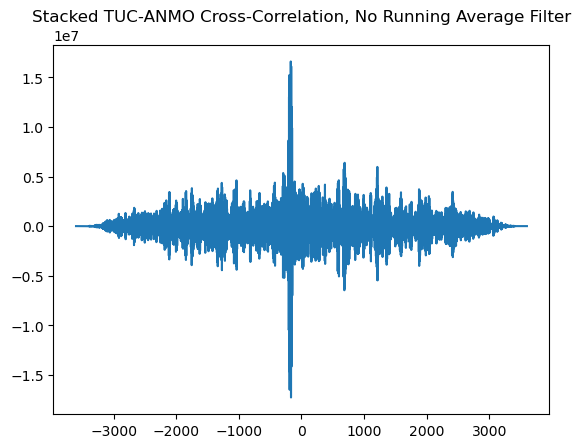

Correlation took 1.1629359000362456 seconds


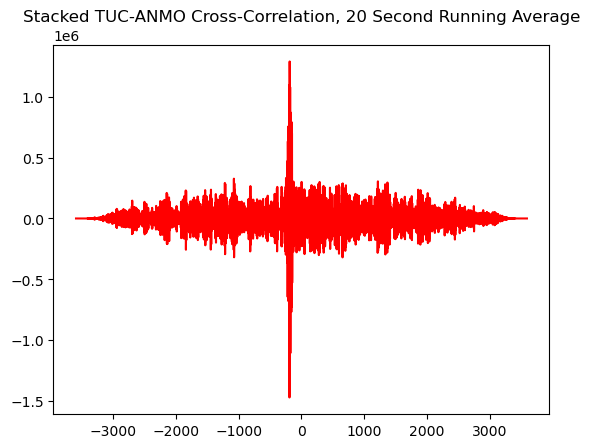

In [11]:
from correlation import prep_files as prep
from correlation import cross_correlate_ambient_noise as corr
import matplotlib.pyplot as plt
import time

station1_files, station2_files = prep.find_station_files('ANMO', 'TUC', './Example_Traces') # Finding correlation files
df1, df2 = prep.get_info_from_file_name(station1_files, station2_files, name_structure=None) # Pulling them into a dataframe using metadata
                                                                                             # from the file name
pairs_list = prep.create_corresponding_files_list(df1, df2) # Create a list of file pairs

start_time = time.perf_counter()

xcorr_list, xcorr_times = corr.multi_correlate(pairs_list,time_method='seconds') # Cross-correlating them
xcorr_stack = corr.xcorr_stack(xcorr_list)
plt.plot(xcorr_times,xcorr_stack)
plt.title('Stacked TUC-ANMO Cross-Correlation, No Running Average Filter')
plt.show()

end_time = time.perf_counter()

print(f'Correlation took {end_time - start_time} seconds')

xcorr_averaged, xcorr_averaged_times = corr.running_average_filter(xcorr_stack,xcorr_times,avg_window=20)
plt.plot(xcorr_averaged_times, xcorr_averaged,'r-')
plt.title('Stacked TUC-ANMO Cross-Correlation, 20 Second Running Average')
plt.show()